In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append(r'..\src')

from sklearn.manifold import TSNE

import pandas as pd
import forgi.visual.mplotlib as fvm
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering
import matplotlib.patheffects as path_effects
from forgi.graph.bulge_graph import BulgeGraph
import matplotlib.pyplot as plt
from tqdm import tqdm

from MGfold import mgfold, mg_dot_bracket
import ast

from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:

def get_part_before_colon(input_string):

    if ':' in input_string:
        return input_string.split(':')[0]
    else:
        return input_string
    
def BoF_in_df(df):    
    words = []
    for i in tqdm(range(len(df))):
        for j in range(len(df['faces'][i])):
            word_pair = (get_part_before_colon(df['faces'][i][j]), df['energy_faces'][i][j])
            if word_pair not in words:
                words.append(word_pair)
    
    vecotr_list = []
    for i in tqdm(range(len(df))):
        binary_array = np.zeros(len(words), dtype=int)
        for j in range(len(df['faces'][i])):
            binary_array[words.index((get_part_before_colon(df['faces'][i][j]), df['energy_faces'][i][j]))] += 1
        vecotr_list.append(binary_array)
    
    # Apply function to each row
    df['binary_array'] = vecotr_list
    X_raw = np.zeros((len(df), len(words)), dtype=int)
    for count, desc in enumerate(df['binary_array']):
        X_raw[count, :] = desc
    
    return X_raw, words


df = pd.read_csv(r'..\data\fold_published.csv')
df['faces'] = df['faces'].apply(ast.literal_eval)
df['energy_faces'] = df['energy_faces'].apply(ast.literal_eval)
print('Numeber of unique sequences after preprocessing removing percentile:',len(df))



Numeber of unique sequences after preprocessing removing percentile: 4450


In [3]:
X_raw0, words0 = BoF_in_df(df)

100%|██████████| 4450/4450 [00:00<00:00, 8201.48it/s]


In [4]:


def run_nmf( X ):

    n_components = 25
    init = "nndsvda"
    nmf= NMF(
    n_components=n_components,
    random_state=42,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.99,
    ).fit(X)

    # Get the topic distribution for each point in X012
    topic_distribution = nmf.transform(X)
    W = nmf.components_
    # Create a label list where each element is the topic associated with the corresponding point
    labels = [topic_probs.argmax() for topic_probs in topic_distribution]
    #plot_top_words(nmf, np.asarray(words)[mask], n_top_words, "Topics in LDA model")
    return labels, topic_distribution,  W,  n_components 

labels , topic,  W ,  n_components = run_nmf(X_raw0)


colors =np.log(df['Count'])
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=1, perplexity=50).fit_transform(topic)
#plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')
#plt.show()

c:\Users\clima\anaconda3b\envs\aptamers_fold\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


c:\Users\clima\anaconda3b\envs\aptamers_fold\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


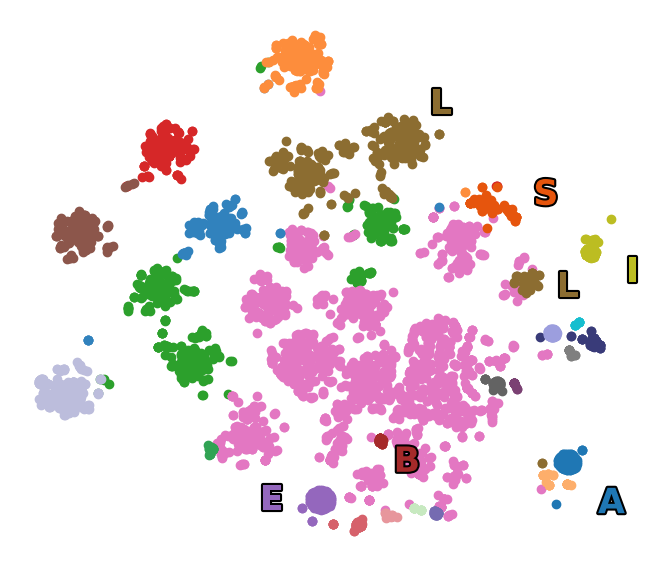

In [5]:


# Assume X_embedded and topic are already defined and prepared

plt.figure(figsize=(7, 6))
n_clusters = 25  # Define the number of clusters
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)

# Fit the model and predict cluster labels
cluster_labels = spectral_clustering.fit_predict(topic)

# Define the letters and colors
letters = list(string.ascii_uppercase[:n_clusters])  # Adjusted to match the number of clusters
colors = [
    '#1f77b4', 'brown', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#8c6d31', '#d6616b', '#7b4173', '#3182bd',
    '#9c9ede', '#756bb1', '#636363', '#e6550d', '#fd8d3c',
    '#31a354', '#c7e9c0', '#fdae6b', '#e7969c', '#bcbddc',
    '#dadaeb', '#c6dbef', '#9e9ac8', '#6baed6', '#bdbdbd'
]

# Indices of clusters to highlight with letters
highlight_indices = {0, 1, 4, 8, 11, 18}

# Invert the x and y coordinates to rotate by 180°
X_embedded_rotated = -X_embedded

# Plot each cluster
for cluster_idx in range(n_clusters):
    cluster_points = X_embedded_rotated[cluster_labels == cluster_idx]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_idx], label=f'Cluster {cluster_idx+1}')
    
    # Add a letter near clusters with specified indices
    if cluster_idx in highlight_indices:
        # Calculate the position to place the letter on the right of the cluster
        max_x = np.max(cluster_points[:, 0])
        mean_y = np.mean(cluster_points[:, 1])
        if cluster_idx == 8:
            plt.text(max_x +3, mean_y - 4.7, letters[cluster_idx], color=colors[cluster_idx],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
        elif cluster_idx == 0:
            plt.text(max_x +3.2, mean_y-9 , letters[cluster_idx], color=colors[cluster_idx],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
        elif cluster_idx == 11:
            plt.text(max_x/2-2 , mean_y +15 , letters[cluster_idx], color=colors[cluster_idx],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
            plt.text(max_x +3, mean_y -25, letters[cluster_idx], color=colors[cluster_idx],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
        elif cluster_idx == 18:
            plt.text(max_x +3.5 , mean_y +2.5, letters[cluster_idx], color=colors[cluster_idx],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
        elif cluster_idx == 4:
            plt.text(max_x -14 , mean_y , letters[cluster_idx], color=colors[cluster_idx],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])
        else:
            plt.text(max_x + 2.2, mean_y - 4.7, letters[cluster_idx], color=colors[cluster_idx],
                     fontsize=25, ha='left', va='center', weight='bold',
                     path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])

cluster_idx = 1
cluster_points = X_embedded_rotated[cluster_labels == cluster_idx]
plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_idx], label=f'Cluster {cluster_idx+1}')

plt.tight_layout()
plt.axis('off')
plt.show()


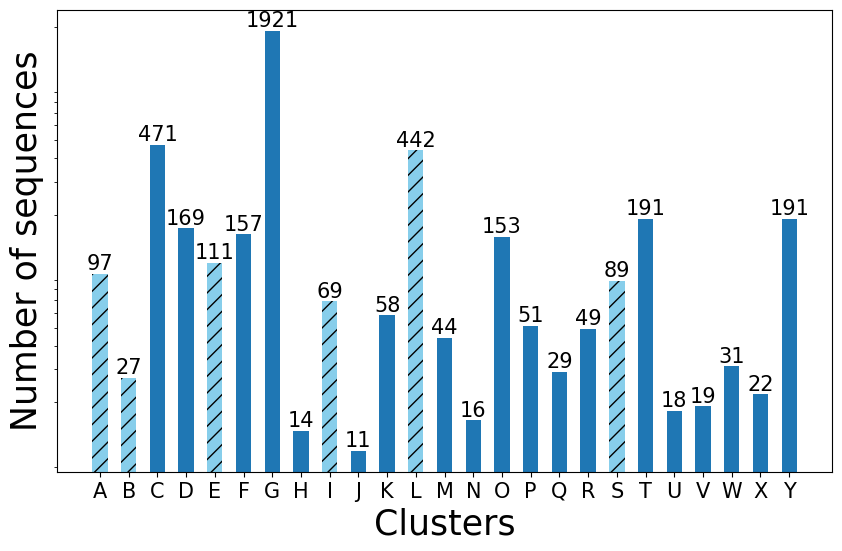

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import string

plt.figure(figsize=(10, 6))

# Example data
arr_lab = np.asarray(cluster_labels)
arr_lab_hc = np.asarray(cluster_labels)[df['Count'] >= 1000]

d = n_components  # Number of unique labels

# Count occurrences of each label
counts = np.bincount(arr_lab, minlength=d)
counts_hc = np.bincount(arr_lab_hc, minlength=d)

# Increase spacing between bars by modifying x positions
spacing_multiplier = 1.5  # Adjust this value to control the space between bars
x_positions = np.arange(d) * spacing_multiplier  # Increasing spacing between bars

# Create the bar plot with increased spacing
bars = plt.bar(x_positions, counts)

# Highlight the bar at the given index with stripes and add counts on top
for i, bar in enumerate(bars):
    height = bar.get_height()
    if counts_hc[i] > 0:
        # Apply hatching (stripes) to the specific bar
        bar.set_hatch('//')
        bar.set_facecolor('skyblue')
    
    # Add the count on top of each bar
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f}', 
             ha='center', va='bottom', fontsize=15)

# Generate letters for x-ticks
letters = list(string.ascii_uppercase[:d])  # First d letters from A, B, C, ...

# Set y-axis to log scale
plt.yscale('log')
# Add x-ticks with letters
plt.yticks([])
plt.xticks(x_positions, letters, fontsize=15)




# Add labels for x and y axes
plt.xlabel('Clusters', fontsize=25)
plt.ylabel('Number of sequences', fontsize=25)
#plt.savefig('clusters_topics.png')
# Show plot
plt.show()



In [7]:
s = set(cluster_labels[df['Count'] >=1000])
print(s)
for e in s:
    print(letters[e])
sum_elem = 0
for  c in s:
    sum_elem += np.count_nonzero(cluster_labels ==c)
   
sum_elem

{0, 1, 4, 8, 11, 18}
A
B
E
I
L
S


835

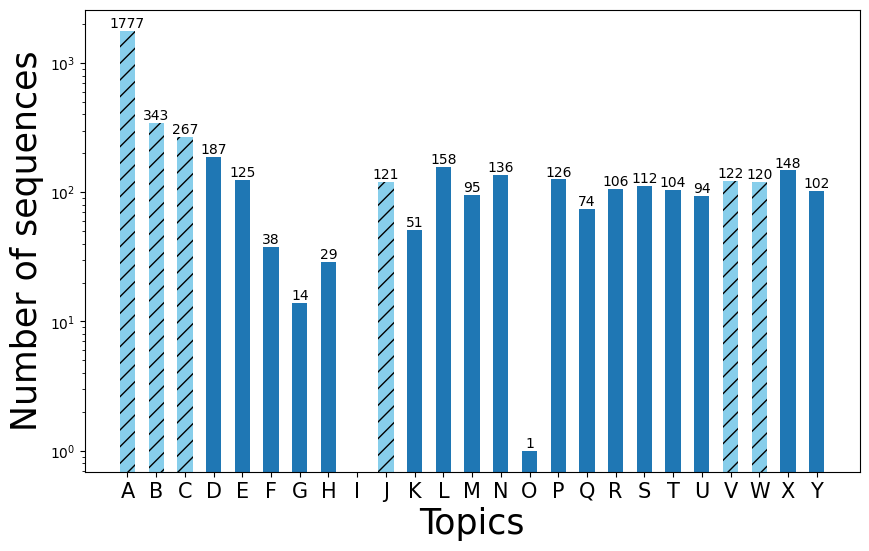

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import string


plt.figure(figsize=(10, 6))

# Example data
arr_lab = np.asarray(labels)
arr_lab_hc = np.asarray(labels)[df['Count'] >= 1000]

d = n_components  # Number of unique labels

# Count occurrences of each label
counts = np.bincount(arr_lab, minlength=d)
counts_hc = np.bincount(arr_lab_hc, minlength=d)

# Increase spacing between bars by modifying x positions
spacing_multiplier = 1.5  # Adjust this value to control the space between bars
x_positions = np.arange(d) * spacing_multiplier  # Increasing spacing between bars

# Create the bar plot with increased spacing
bars = plt.bar(x_positions, counts)

# Highlight the bar at the given index with stripes and add counts on top
for i, bar in enumerate(bars):
    height = bar.get_height()
    if counts_hc[i] > 0:
        # Apply hatching (stripes) to the specific bar
        bar.set_hatch('//')
        bar.set_facecolor('skyblue')
    
    # Add the count on top of each bar
    if counts[i]>0:
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f}', 
            ha='center', va='bottom', fontsize=10)

# Generate letters for x-ticks
letters = list(string.ascii_uppercase[:d])  # First d letters from A, B, C, ...

# Set y-axis to log scale
plt.yscale('log')

# Add x-ticks with letters
plt.xticks(x_positions, letters, fontsize=15)



# Add labels for x and y axes
plt.xlabel('Topics', fontsize=25)
plt.ylabel('Number of sequences', fontsize=25)

# Show plot
plt.show()
